# Importing the Dataset from Kaggle

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json
token = {"username":"ris320","key":"dcc2deb417503b273221e7b4ec651938"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized -p /content

In [0]:
!unzip diabetic-retinopathy-resized.zip

In [0]:
!ls

# Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
from google.colab.patches import cv2_imshow
import glob
import math
from sklearn.utils import class_weight
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers.core import Flatten, Dense, Dropout
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.optimizers import SGD, Adam, Adamax,rmsprop
# from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from PIL import Image
#from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#from sklearn.utils import class_weight
#from sklearn.preprocessing import OneHotEncoder
# from catboost import CatBoostClassifier
#import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
# from keras.models import Sequential
# from keras.layers.core import Flatten, Dense, Dropout
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.optimizers import SGD, Adam, Adamax,rmsprop
# from keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.python.keras.utils.data_utils import Sequence
# from imblearn.over_sampling import SMOTE
# from imblearn.keras import balanced_batch_generator
# from imblearn.under_sampling import  RandomUnderSampler
from lightgbm import LGBMClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.over_sampling import  RandomOverSampler
# import pickle

In [0]:
 #!pip install tensorflow==2.0
#!pip install catboost
!pip install lightgbm

# Importing the dataset

In [0]:
dataset=pd.read_csv('trainLabels_cropped.csv')


# Exploratory Data Analysis

In [0]:
print(dataset.head(10))

   Unnamed: 0  Unnamed: 0.1     image  level
0           0             0   10_left      0
1           1             1  10_right      0
2           2             2   13_left      0
3           3             3  13_right      0
4           4             4   15_left      1
5           5             5  15_right      2
6           6             6   16_left      4
7           7             7  16_right      4
8           8             8   17_left      0
9           9             9  17_right      1


In [0]:
dataset.drop(columns={'Unnamed: 0','Unnamed: 0.1'},axis=1,inplace=True)


In [0]:
print(dataset.head(10))

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
5  15_right      2
6   16_left      4
7  16_right      4
8   17_left      0
9  17_right      1


In [0]:
print(dataset.isnull().sum()/len(dataset))

image    0.0
level    0.0
dtype: float64


In [0]:
print(dataset.dtypes)

image    object
level     int64
dtype: object


In [0]:
print(len(dataset))

35108


Text(0, 0.5, 'Total Image count')

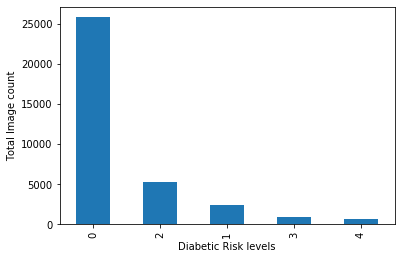

In [0]:
dataset['level'].value_counts().plot(kind='bar')
plt.xlabel('Diabetic Risk levels')
plt.ylabel('Total Image count')

In [0]:
train_dir='/content/resized_train_cropped/resized_train_cropped/'
train_img=['/content/resized_train_cropped/resized_train_cropped/{}'.format(i) for i in os.listdir(train_dir)]

In [0]:
train_img

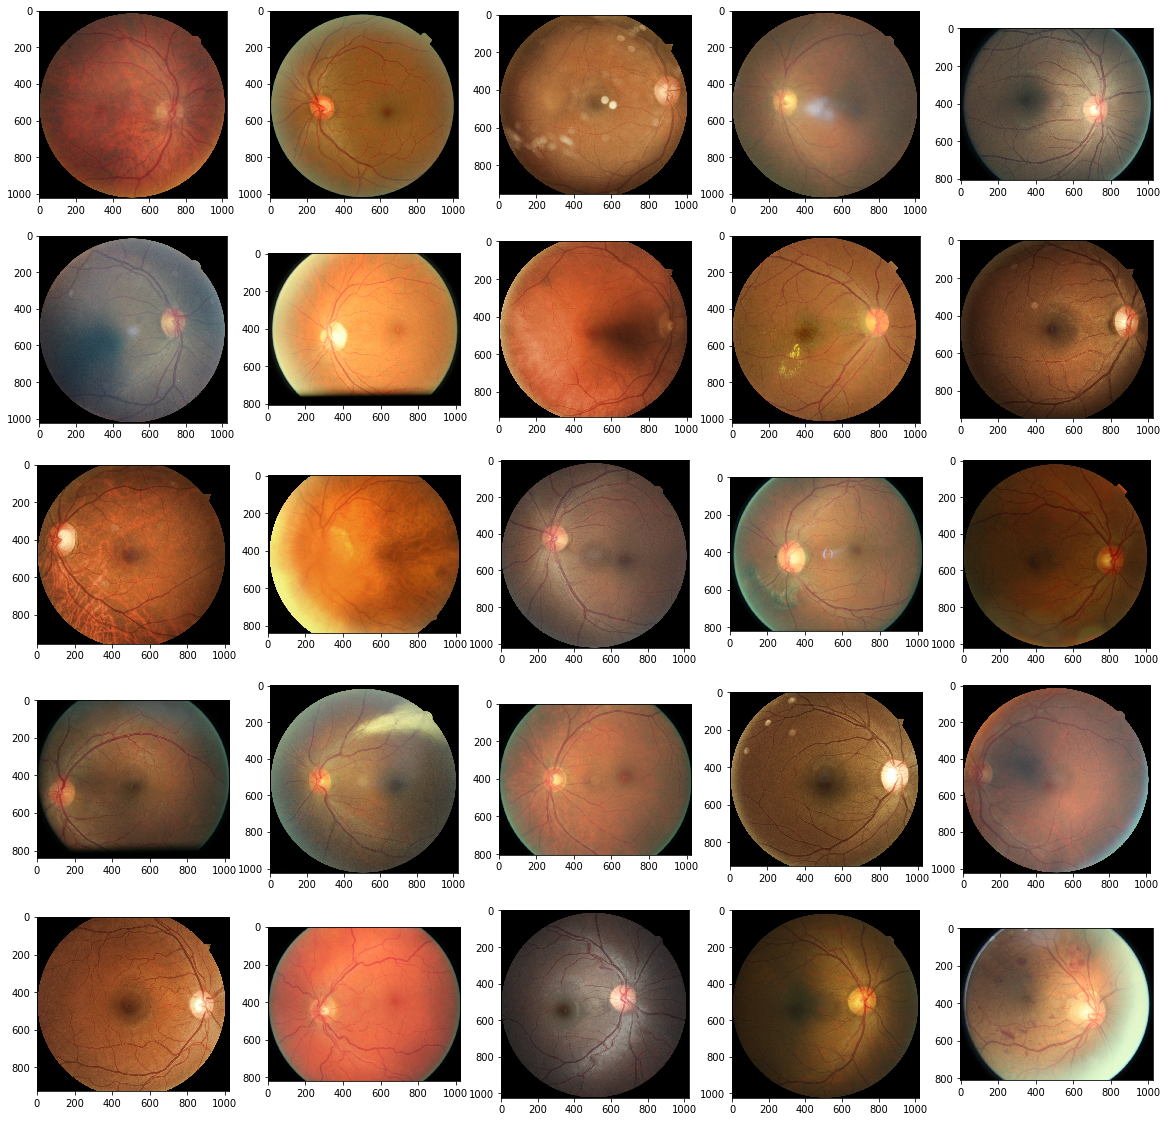

In [0]:
#Visualizing the Image
def plot_image():
  _, axs = plt.subplots(5, 5, figsize=(20, 20))
  axs = axs.flatten()  
  for img,ax in zip(train_img,axs):  
      image=cv2.imread(img) 
      # show the plotting graph of an image  
      image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
      ax.imshow(image)     
  plt.show()

plot_image()

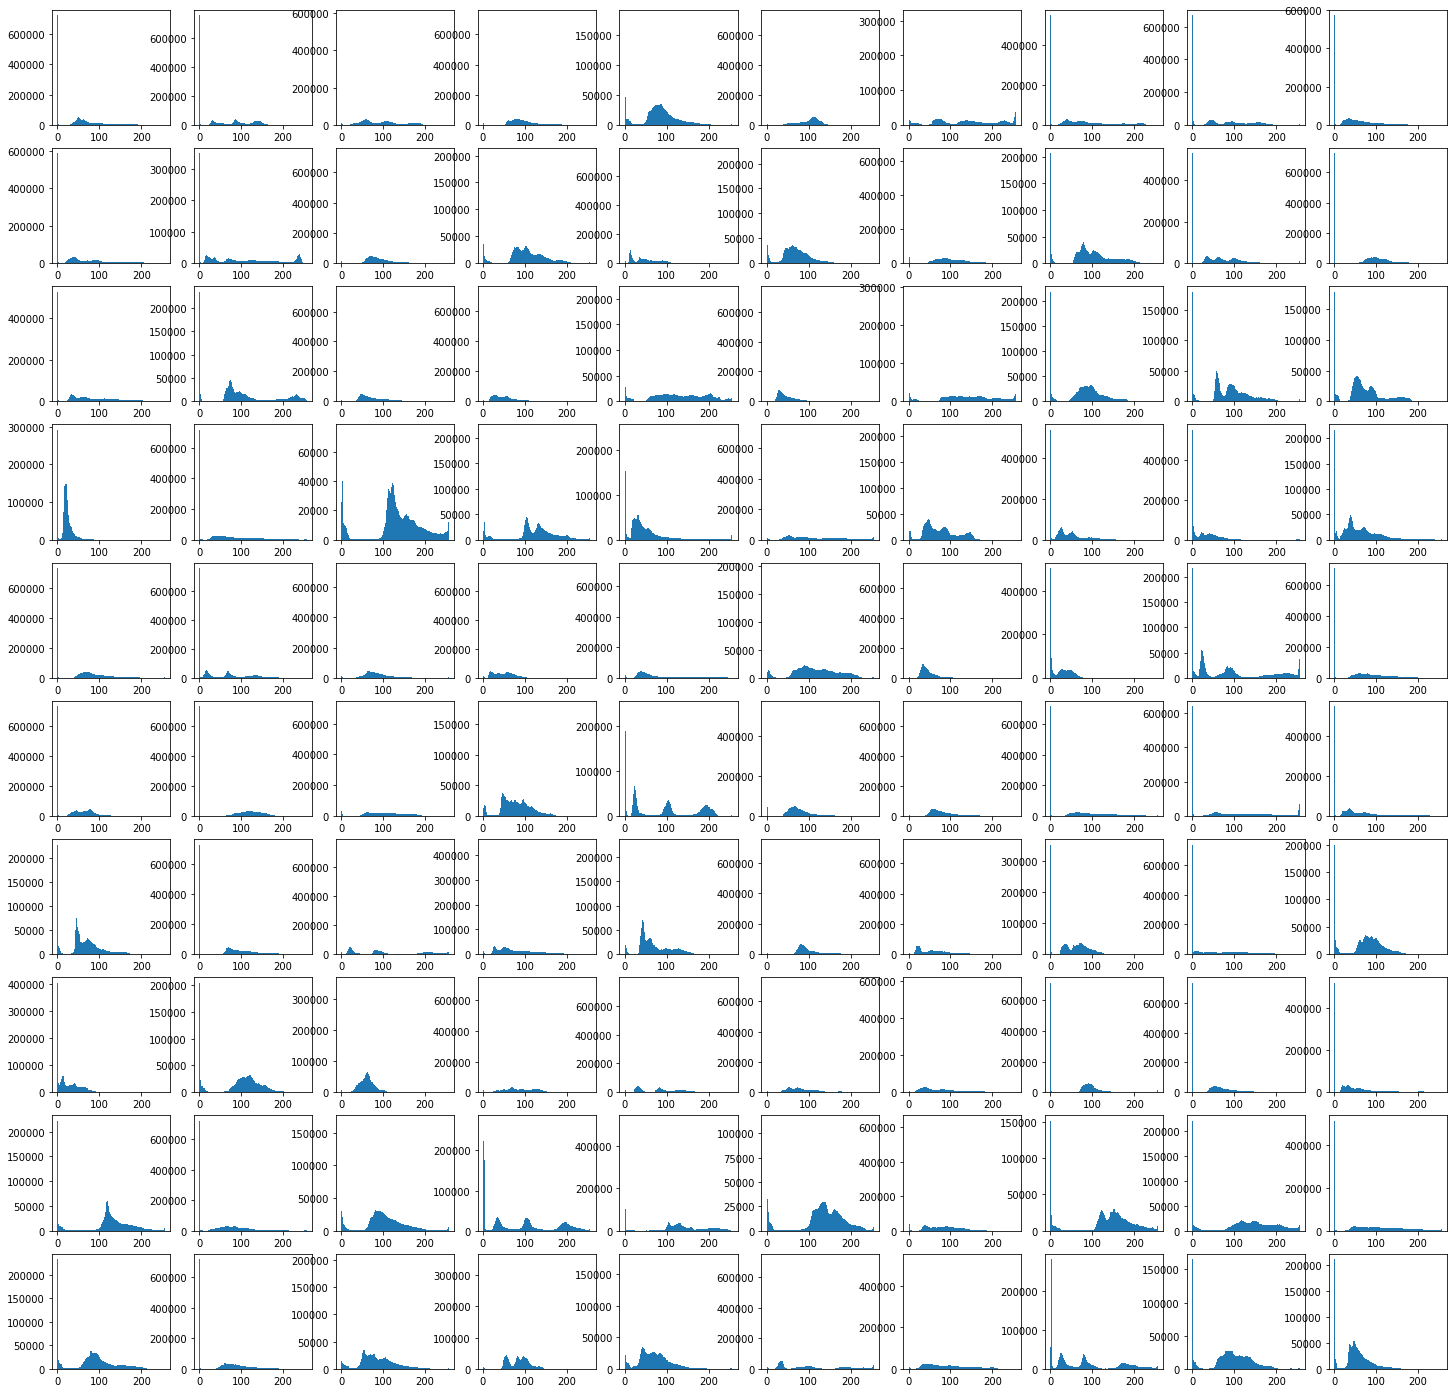

In [0]:
# Visualizing the Intensity Histogram of Images
def draw_intensity_plot():
  _, axs = plt.subplots(10, 10, figsize=(25, 25))
  axs = axs.flatten()  
  for img,ax in zip(train_img,axs):
    img = cv2.imread(img)
    image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.hist(image.ravel(),256,[0,256])
  plt.show()

draw_intensity_plot()


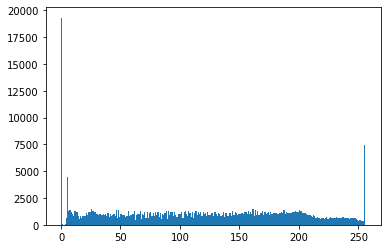

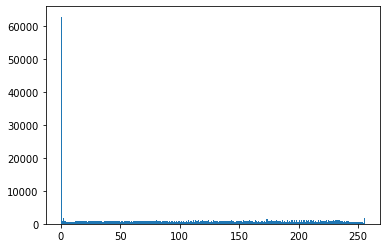

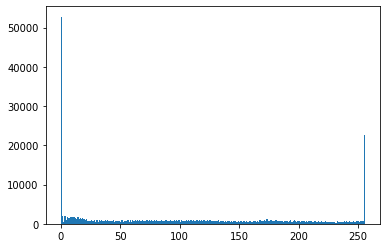

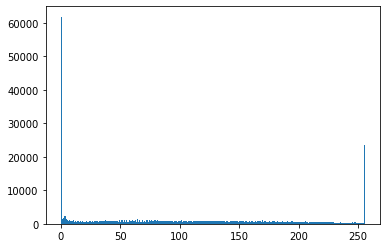

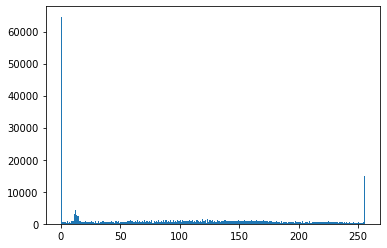

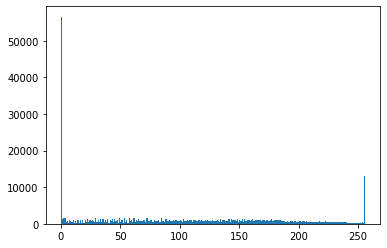

In [0]:
# Histogram Equalization
def histogram_equalize(img): 
  for img in train_img[4:10]:
    img=cv2.imread(img)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv=cv2.resize(img_yuv,(300,300))
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) 
    #res = np.hstack((image, equ))
    plt.hist(img_output.ravel(),256,[0,256])
    plt.show()
histogram_equalize(train_img)


In [0]:
# Loading the Images
# temp = []
# for img_name in dataset.image+str('.jpeg'):
#     img_path=os.path.join(train_dir,img_name)
#     img=cv2.imread(img_path)
#     image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     # img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     #img_yuv=cv2.resize(img_yuv,(100,100))
#   # equalize the histogram of the Y channel
#     #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#     #img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     img = cv2.resize(image, (115,115))
#     img = img.astype('float32')  
#     temp.append(img)

# train = np.stack(temp)

# Feature Extraction using Pretrained VGG16

In [0]:

model = VGG16(weights='imagenet', include_top=False)
model.summary()
vgg16_feature_list = []

for img_name in dataset.image+str('.jpeg'):
    img_path=os.path.join(train_dir,img_name)  
    img = image.load_img(img_path, target_size=(200, 200))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

train = np.array(vgg16_feature_list)




In [0]:
 #train=train.astype('float32')

In [0]:
# Normalizing the Images
# train=train/255.

In [0]:
train_y=dataset.loc[:,'level']

In [0]:
train_y

0        0
1        0
2        0
3        0
4        1
        ..
35103    0
35104    0
35105    0
35106    0
35107    1
Name: level, Length: 35108, dtype: int64

In [0]:
train_y=train_y.astype('category')

In [0]:
# print(train_y.head(10))

print(train_y)

In [0]:
#  train_y=pd.get_dummies(train_y)

In [0]:
#  print(train_y.head(10))

# Splitting into Train,Test and  Validation

In [0]:

train_x,test_x,train_y,test_y=train_test_split(train,train_y,test_size=0.30)


In [0]:
# print(len(train_x))
test_x,val_x,test_y,val_y=train_test_split(train_x,train_y,test_size=0.30)


In [0]:
len(train_y)

In [0]:
train_x.shape

In [0]:
# Handling Imbalanced Classes
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)
#print('Class weights:',class_weights)
class_weights={0:0.2726,1:2.8962,2:1.3141,3:8.004,4:9.9092}


In [0]:
train_x.shape

# Training the Model

In [0]:
# model = tf.keras.Sequential()

# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(115,115,3)))
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.2))
 
# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dropout(0.2))
 
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Dense(5, activation='softmax'))


# model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
#               loss='sparse_categorical_crossentropy',
#           metrics=['accuracy'])

In [0]:
# train_y=np.array(train_y)
# val_y=np.array(val_y)
# type(train_y)
# type(train_x)
# type(val_x)


In [0]:
# history=model.fit(train_x,train_y,          
#         epochs=5,
#         validation_data=(val_x,val_y),class_weight=class_weights)


# Training and Validation Accuracy

In [0]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Training and Validation Loss

In [0]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [0]:
#SMOTE

# from imblearn.over_sampling import SMOTE

# smote=SMOTE('minority')

# train_x,train_y_1=smote.fit_sample(train_x,train_y)

# print(train_x.shape,train_y.shape)


# #  Random UnderSampling

# rus=RandomUnderSampler('majority',random_state=42)

# X_res,y_res=rus.fit_resample(train_x,train_y.iloc[:,0])


#Random OverSampling

# ros=RandomOverSampler('minority',random_state=42)

# X_res,y_res= ros.fit_resample(train_x,train_y.iloc[:,1])


In [0]:
# y_res=pd.Series(y_res)
# y_res.value_counts().plot(kind='bar')
# plt.xlabel('level')
# plt.ylabel('count')

# Fitting Classifier to the Training Data

In [0]:
# class_weights=dict({0:1.5,1:12,2:11,3:30,4:40})

# Level 0-parameters n_estimators=300,max_depth=6


# classifier=RandomForestClassifier(n_estimators=300,max_depth=6)

# # classifier=BalancedRandomForestClassifier(n_estimators=200,max_depth=7)

# classifier.fit(X_res,y_res)

# classifier = CatBoostClassifier(iterations=2000, learning_rate=0.01, l2_leaf_reg=3.5, depth=9, rsm=0.98, loss_function= 'MultiClass', eval_metric='Accuracy',use_best_model=True,random_seed=42,class_weights=class_weights,
#                                 gpu_ram_part=0.7)

# classifier=CatBoostClassifier(iterations=18,depth=6,task_type='GPU'
#                               ,boosting_type='Plain',max_ctr_complexity=1,gpu_ram_part=0.7,
#                             gpu_cat_features_storage='CpuPinnedMemory',metrics='accuracy')
# lgb_train = lgb.Dataset(train_x, train_y)
# lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

# classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
params = {
	# ...
    'objective': 'multiclass',
    'num_class':5,
    'metric': 'multi_logloss',
    'class_weight':class_weights
}

# classifier.fit(train_x,train_y)
classifier= LGBMClassifier(boosting_type='gbdt',objective='multiclass',num_class=5,metric='multi_logloss',class_weight=class_weights)
classifier.fit(train_x,train_y)


# classifier.fit(train_x,train_y.iloc[:,0])

In [0]:
#Hyperparameter Tuning

#Randomized Search CV

# param_list={'n_estimators':[100,200,300],
#              'max_depth':[1,2,3,4]}
# n_iter_search = 10

# random_search = RandomizedSearchCV(classifier, param_distributions=param_list,
#                                    n_iter=n_iter_search)

# random_search.fit(X_res,y_res)

# print(random_search.best_params_)

In [0]:
# # # Predicting the train set results
y_pred_train=classifier.predict(train_x)

# # Predicting the Test set results
y_pred_test=classifier.predict(test_x)



In [0]:
#Checking the Accuracy

print("Training Accuracy is:",accuracy_score(train_y,y_pred_train))

print("Testing Accuracy is:",accuracy_score(test_y,y_pred_test))


Training Accuracy is: 0.881383519837233
Testing Accuracy is: 0.8808278107196837


In [0]:
# Confusion Matrix for training data

cm=confusion_matrix(y_target=train_y,y_predicted=y_pred_train)


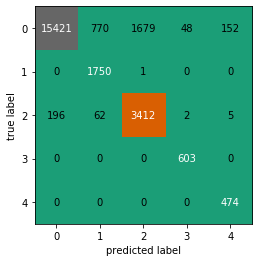

In [0]:
fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2')

plt.show()

In [0]:
# # # Confusion Matrix for test data
cm=confusion_matrix(y_target=test_y,y_predicted=y_pred_test)



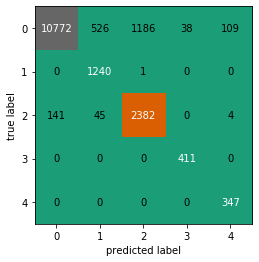

In [0]:
fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2')
plt.show()

In [0]:
# Training Classification Report

print(classification_report(train_y,y_pred_train))



              precision    recall  f1-score   support

           0       0.99      0.85      0.92     18070
           1       0.68      1.00      0.81      1751
           2       0.67      0.93      0.78      3677
           3       0.92      1.00      0.96       603
           4       0.75      1.00      0.86       474

    accuracy                           0.88     24575
   macro avg       0.80      0.96      0.86     24575
weighted avg       0.91      0.88      0.89     24575



In [0]:
# Testing Classification Report
print("Testing Classification Report")
print(classification_report(test_y,y_pred_test))


Testing Classification Report
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     12631
           1       0.68      1.00      0.81      1241
           2       0.67      0.93      0.78      2572
           3       0.92      1.00      0.96       411
           4       0.75      1.00      0.86       347

    accuracy                           0.88     17202
   macro avg       0.80      0.96      0.86     17202
weighted avg       0.91      0.88      0.89     17202

